In [1]:
#
# Imports
#
import os
from argparse import Namespace
from types import MethodType
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
from sqlalchemy import __version__ as sqlalchemy_version
from sqlalchemy import inspect
from sqlalchemy.sql import func
import astropy.units as u
from astropy.constants import c as lightspeed
from astropy.table import Table, MaskedColumn
#
# DESI software
#
from desiutil.log import get_logger, DEBUG
from desitarget.targetmask import (desi_mask, mws_mask, bgs_mask)
# from desisim.spec_qa import redshifts as dsq_z
from desisurvey import __version__ as desisurvey_version
from desisurvey.ephem import get_ephem, get_object_interpolator
from desisurvey.utils import get_observer
from desispec import __version__ as desispec_version
import desispec.database.redshift as db
#
# Paths to files, etc.
#
specprod = os.environ['SPECPROD'] = 'fuji'
basedir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], specprod)
# surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
# targetdir = os.path.join(basedir, 'targets')
# fibassigndir = os.path.join(basedir, 'fiberassign')
# os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
# os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
# os.environ['PIXPROD'] = 'mini'
# os.environ['SPECPROD'] = 'mini'
# reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
# simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
# os.environ['DESI_SPECTRO_DATA'] = simdatadir
#
# Initialize ephemerides, to find Moon, etc.
#
os.environ['DESISURVEY_OUTPUT'] = os.environ['SCRATCH']
ephem = get_ephem()
#
# get_ephem() will run freeze_iers(), so we import these after that.
#
from astropy.time import Time
from astropy.coordinates import ICRS
#
# Working directory.
#
workingdir = os.getcwd()
print(workingdir)
print(f'sqlalchemy=={sqlalchemy_version}')
print(f'desispec=={desispec_version}')
print(f'desisurvey=={desisurvey_version}')

INFO:iers.py:82:freeze_iers: Freezing IERS table used by astropy time, coordinates.
INFO:ephem.py:80:get_ephem: Restored ephemerides for (2019-01-01,2027-12-31) from /pscratch/sd/r/ronitnag/ephem_2019-01-01_2027-12-31.fits.
/global/u2/r/ronitnag/desi
sqlalchemy==1.4.46
desispec==0.57.0.dev7802
desisurvey==0.19.0.dev1131


In [2]:
from desispec.io import read_spectra

In [3]:
spectra_plot_cmap = {'b':'C0', 'r':'C1', 'z':'C2'}

In [36]:
spectra = read_spectra('tmpg5trjbpw.fits', single=True)

INFO:spectra.py:291:read_spectra: iotime 0.020 sec to read tmpg5trjbpw.fits at 2023-04-24T13:38:06.132102


In [37]:
spectra.fibermap

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32
39633414185291844,8,462,8462,4460,0,273.4140060299647,62.30412533319147,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,-403.90875,-37.817368,102100,0.2743804250628955,575,9011,2732p622,623959,4164,SER,0.042602386,9.722912,17.955282,26.997173,14.049936,7.349095,175.90858,61.760757,17.317533,6.2513614,2.9726958,3.3632092,6.2108326,9.338473,3.3632092,6.2108326,9.338473,0,2.0261898,1.0866193,0.2261535,-0.14390159,0,,0.0,0.0,0.0,0.0,N,102100,9,5764607523034234880,514,0,131072,0,0,0,273.4140060299647,62.30412533319147,557,1,252.8459,1,1,-0.002,0.002,0.008,0.008,273.4139860007035,0.0,62.304094234433364,0.0,0.73781025,-403.833,-37.793
39633416995473409,8,440,8440,4496,0,273.4549338004465,62.37712403019393,0.0,0.0,2015.5,5400.0,4611686018427388932,1,TGT,-407.85498,-19.064772,103400,0.24407735268609165,63,9011,2735p625,624629,2049,PSF,0.04198366,0.4905385,1.0275537,1.570931,6.3642926,8.518681,624.2688,254.39441,67.80655,8.417338,3.1982636,0.381921,0.80002755,1.2230875,0.38192117,0.800028,1.2230917,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,N,103400,4,4611686018427388932,0,0,34359738368,0,0,0,273.4549338004465,62.37712403019393,543,1,197.4051,1,1,-0.003,0.003,0.005,0.005,273.45490774196725,0.0,62.37710495557893,0.0,0.789,-407.766,-19.051


In [38]:
spectra.fibermap

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32
39633414185291844,8,462,8462,4460,0,273.4140060299647,62.30412533319147,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,-403.90875,-37.817368,102100,0.2743804250628955,575,9011,2732p622,623959,4164,SER,0.042602386,9.722912,17.955282,26.997173,14.049936,7.349095,175.90858,61.760757,17.317533,6.2513614,2.9726958,3.3632092,6.2108326,9.338473,3.3632092,6.2108326,9.338473,0,2.0261898,1.0866193,0.2261535,-0.14390159,0,,0.0,0.0,0.0,0.0,N,102100,9,5764607523034234880,514,0,131072,0,0,0,273.4140060299647,62.30412533319147,557,1,252.8459,1,1,-0.002,0.002,0.008,0.008,273.4139860007035,0.0,62.304094234433364,0.0,0.73781025,-403.833,-37.793
39633416995473409,8,440,8440,4496,0,273.4549338004465,62.37712403019393,0.0,0.0,2015.5,5400.0,4611686018427388932,1,TGT,-407.85498,-19.064772,103400,0.24407735268609165,63,9011,2735p625,624629,2049,PSF,0.04198366,0.4905385,1.0275537,1.570931,6.3642926,8.518681,624.2688,254.39441,67.80655,8.417338,3.1982636,0.381921,0.80002755,1.2230875,0.38192117,0.800028,1.2230917,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,N,103400,4,4611686018427388932,0,0,34359738368,0,0,0,273.4549338004465,62.37712403019393,543,1,197.4051,1,1,-0.003,0.003,0.005,0.005,273.45490774196725,0.0,62.37710495557893,0.0,0.789,-407.766,-19.051


In [42]:
num = len(spectra.fibermap)

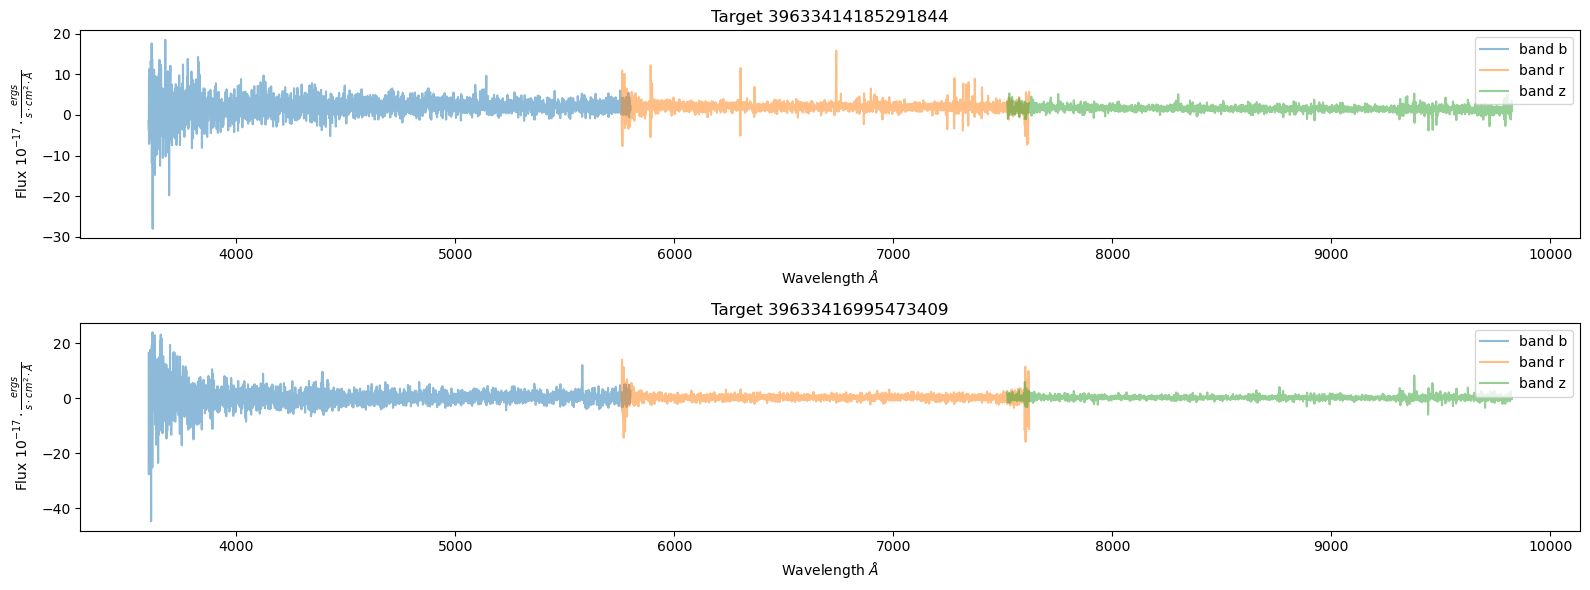

In [43]:
fig, axs = plt.subplots(num, 1, figsize=(16,num*3))
if num == 1:
    axs = np.array([axs])
for i in range(num):
    axs[i].set_title(f'Target {spectra.fibermap["TARGETID"][i]}')
    for band in spectra.bands:
        axs[i].plot(spectra.wave[band], spectra.flux[band][i], f'{spectra_plot_cmap[band]}-', alpha=0.5, label=f'band {band}')
        axs[i].set_xlabel(r'Wavelength $Å$')
        axs[i].set_ylabel(r'Flux $10^{-17} \cdot \frac{ergs}{s \cdot cm^2 \cdot Å}$')
        axs[i].legend(loc="upper right")
fig.tight_layout()

In [22]:
fib = np.where(spectra.fibermap['TARGETID'] == 39633414185291967)
assert len(fib) == 1
ispec = fib[0][0]

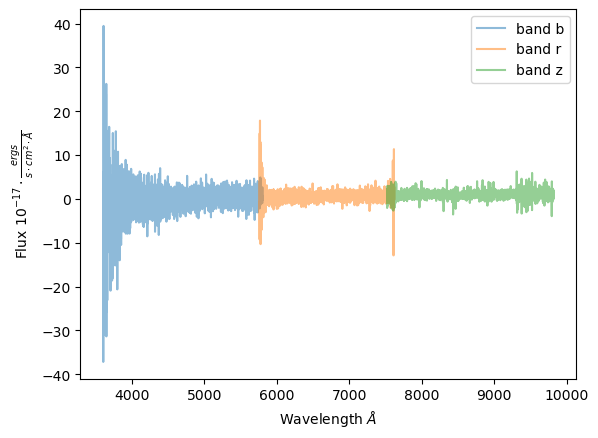

In [24]:

for band in spectra.bands:
    plt.plot(spectra.wave[band], spectra.flux[band][ispec], f'{spectra_plot_cmap[band]}-', alpha=0.5, label=f'band {band}')
plt.xlabel(r'Wavelength $Å$')
plt.ylabel(r'Flux $10^{-17} \cdot \frac{ergs}{s \cdot cm^2 \cdot Å}$')
plt.legend(loc="upper right")